# FITS File Viewer

Quick viewer for any FITS file or folder. Just change the `TARGET` variable below.


In [ ]:
# ============================================
# CONFIGURATION - Change this to view different files
# ============================================

# Point to a single file or a folder
TARGET = "../output/difference_images"

# Or specific files:
# TARGET = "../output/difference_images/2014J/2014J_uuu_diff.fits"
# TARGET = "../output/fits_training/2014J/reference"

# ============================================


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import warnings
warnings.filterwarnings('ignore')

def load_fits(filepath):
    """Load FITS file and return data, header, WCS."""
    with fits.open(filepath) as hdul:
        for i, hdu in enumerate(hdul):
            if hdu.data is not None and len(hdu.data.shape) >= 2:
                data = hdu.data.astype(float)
                header = dict(hdu.header)
                if len(data.shape) == 3:
                    data = data[0]
                try:
                    wcs = WCS(hdu.header, naxis=2)
                except:
                    wcs = None
                return data, header, wcs, i
    return None, None, None, None

def show_fits(filepath, ax=None, title=None, cmap='gray', scale='zscale'):
    """Display a single FITS file."""
    filepath = Path(filepath)
    data, header, wcs, ext = load_fits(filepath)
    
    if data is None:
        print(f"Could not load: {filepath}")
        return None
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Choose scaling
    if scale == 'zscale':
        interval = ZScaleInterval()
        vmin, vmax = interval.get_limits(data[np.isfinite(data)])
    elif scale == 'symlog':
        vmax = np.nanpercentile(np.abs(data), 99)
        vmin, vmax = -vmax, vmax
        cmap = 'RdBu_r'
    elif scale == 'log':
        data_pos = np.where(data > 0, data, np.nan)
        vmin = np.nanpercentile(data_pos, 1)
        vmax = np.nanpercentile(data_pos, 99)
    else:
        vmin, vmax = np.nanpercentile(data, [1, 99])
    
    im = ax.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Title with metadata
    if title is None:
        title = filepath.name
    info = f"{title}\n"
    info += f"Shape: {data.shape}, "
    info += f"Range: [{np.nanmin(data):.2g}, {np.nanmax(data):.2g}]"
    if 'DATE-OBS' in header:
        info += f"\nDate: {header['DATE-OBS'][:10]}"
    if 'SN_NAME' in header:
        info += f", SN: {header['SN_NAME']}"
    if 'SIG_MAX' in header:
        info += f", Max σ: {header['SIG_MAX']:.1f}"
    
    ax.set_title(info, fontsize=10)
    
    return data, header

print("✅ Functions loaded")


✅ Functions loaded


In [ ]:
# Find all FITS files in target
target = Path(TARGET)

if target.is_file():
    fits_files = [target]
else:
    fits_files = sorted(target.rglob("*.fits"))

print(f"Found {len(fits_files)} FITS files in {target}")
for f in fits_files[:20]:  # Show first 20
    print(f"  {f.relative_to(target.parent)}")
if len(fits_files) > 20:
    print(f"  ... and {len(fits_files) - 20} more")


Found 15 FITS files in ../output/difference_images
  difference_images/2013gc/2013gc_uuu_diff.fits
  difference_images/2013gc/2013gc_uuu_mask.fits
  difference_images/2013gc/2013gc_uuu_sig.fits
  difference_images/2014J/2014J_uuu_diff.fits
  difference_images/2014J/2014J_uuu_mask.fits
  difference_images/2014J/2014J_uuu_sig.fits
  difference_images/2014ai/2014ai_uuu_diff.fits
  difference_images/2014ai/2014ai_uuu_mask.fits
  difference_images/2014ai/2014ai_uuu_sig.fits
  difference_images/2014bh/2014bh_uuu_diff.fits
  difference_images/2014bh/2014bh_uuu_mask.fits
  difference_images/2014bh/2014bh_uuu_sig.fits
  difference_images/2014bi/2014bi_uvv_diff.fits
  difference_images/2014bi/2014bi_uvv_mask.fits
  difference_images/2014bi/2014bi_uvv_sig.fits


In [ ]:
# Quick filter - uncomment to filter by type:

# Only difference images
fits_files = [f for f in fits_files if '_diff' in f.name]

# Only significance maps
# fits_files = [f for f in fits_files if '_sig' in f.name]

# Only masks
# fits_files = [f for f in fits_files if '_mask' in f.name]

# Specific SN
# fits_files = [f for f in fits_files if '2014J' in str(f)]

print(f"Viewing {len(fits_files)} files")


Viewing 5 files


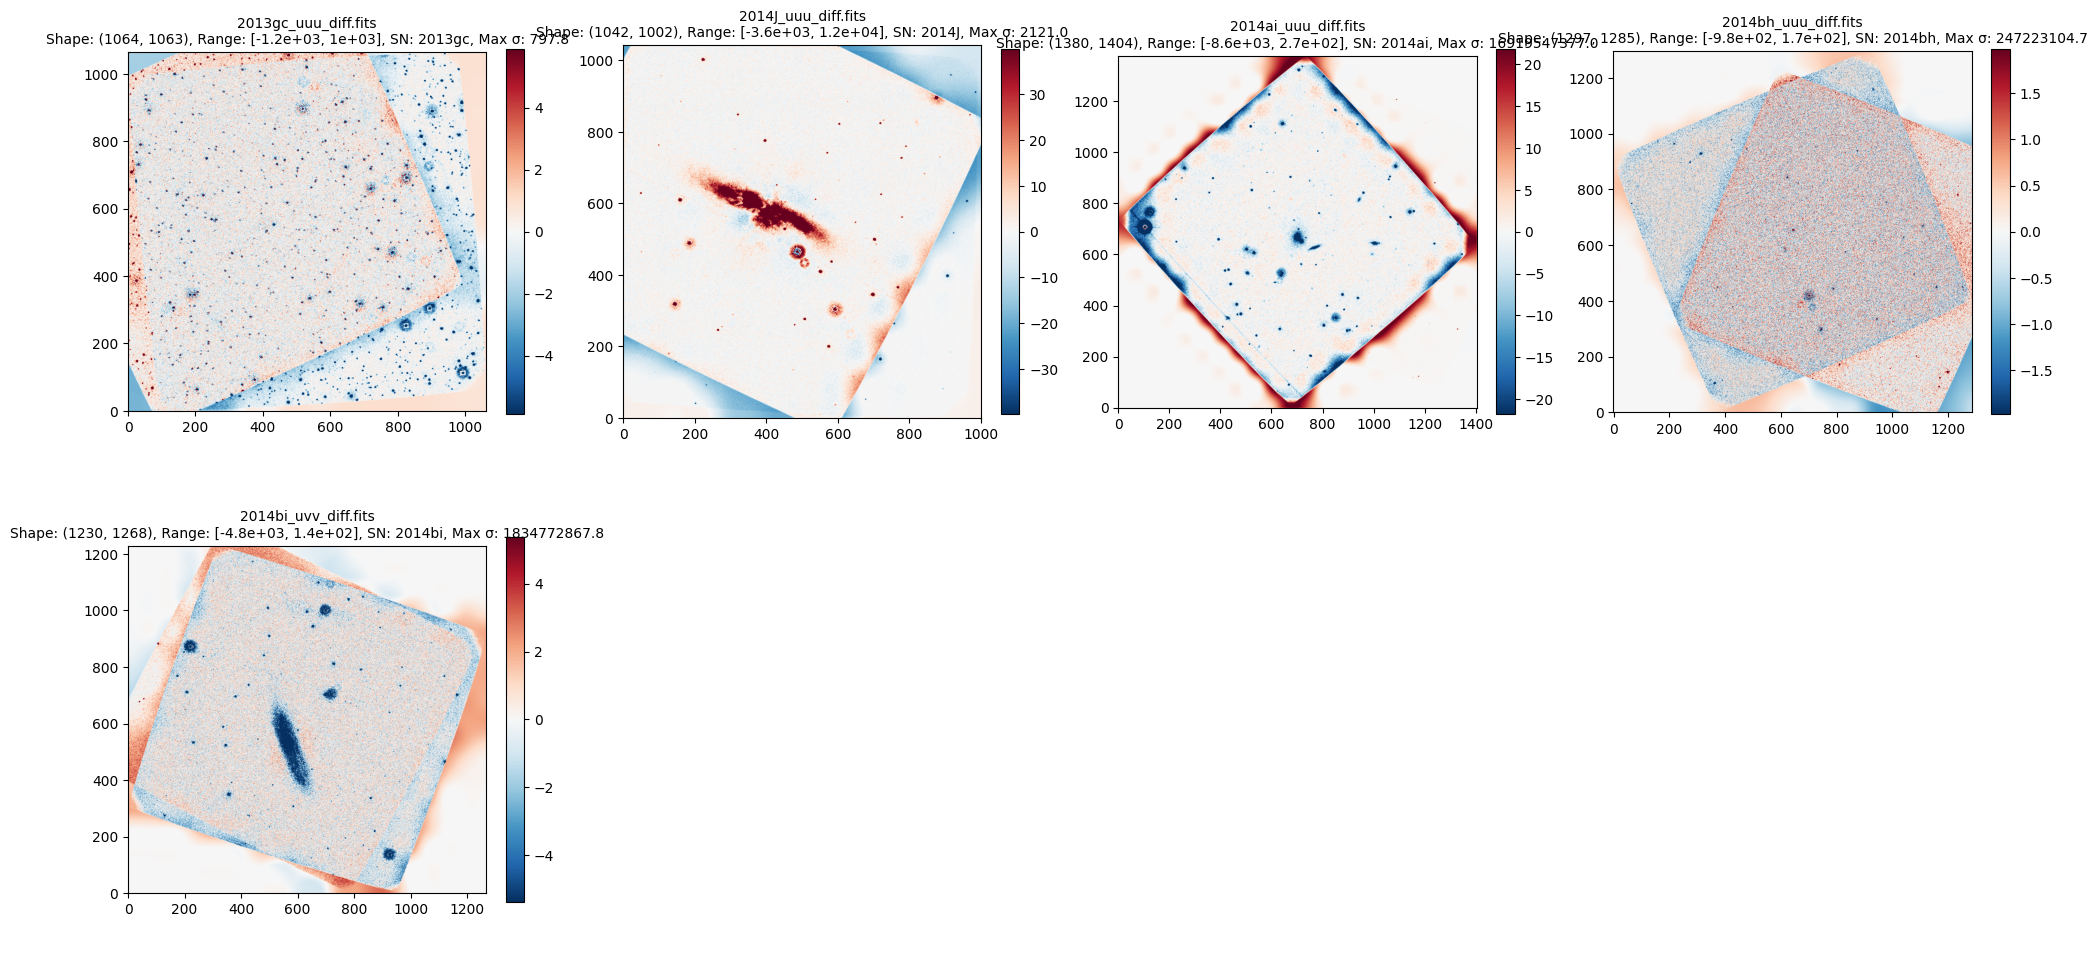

In [ ]:
# View all files in a grid
n_files = len(fits_files)
if n_files == 0:
    print("No FITS files found!")
elif n_files == 1:
    fig, ax = plt.subplots(figsize=(12, 12))
    show_fits(fits_files[0], ax=ax)
    plt.tight_layout()
    plt.show()
else:
    # Calculate grid size
    n_cols = min(4, n_files)
    n_rows = (n_files + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = np.atleast_2d(axes)
    
    for idx, filepath in enumerate(fits_files):
        row, col = idx // n_cols, idx % n_cols
        ax = axes[row, col]
        
        # Auto-detect scale based on filename
        if '_diff' in filepath.name or '_sig' in filepath.name:
            scale = 'symlog'
        else:
            scale = 'zscale'
        
        show_fits(filepath, ax=ax, scale=scale)
    
    # Hide empty axes
    for idx in range(n_files, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


## View a Specific SN's Full Set (diff + sig + mask)


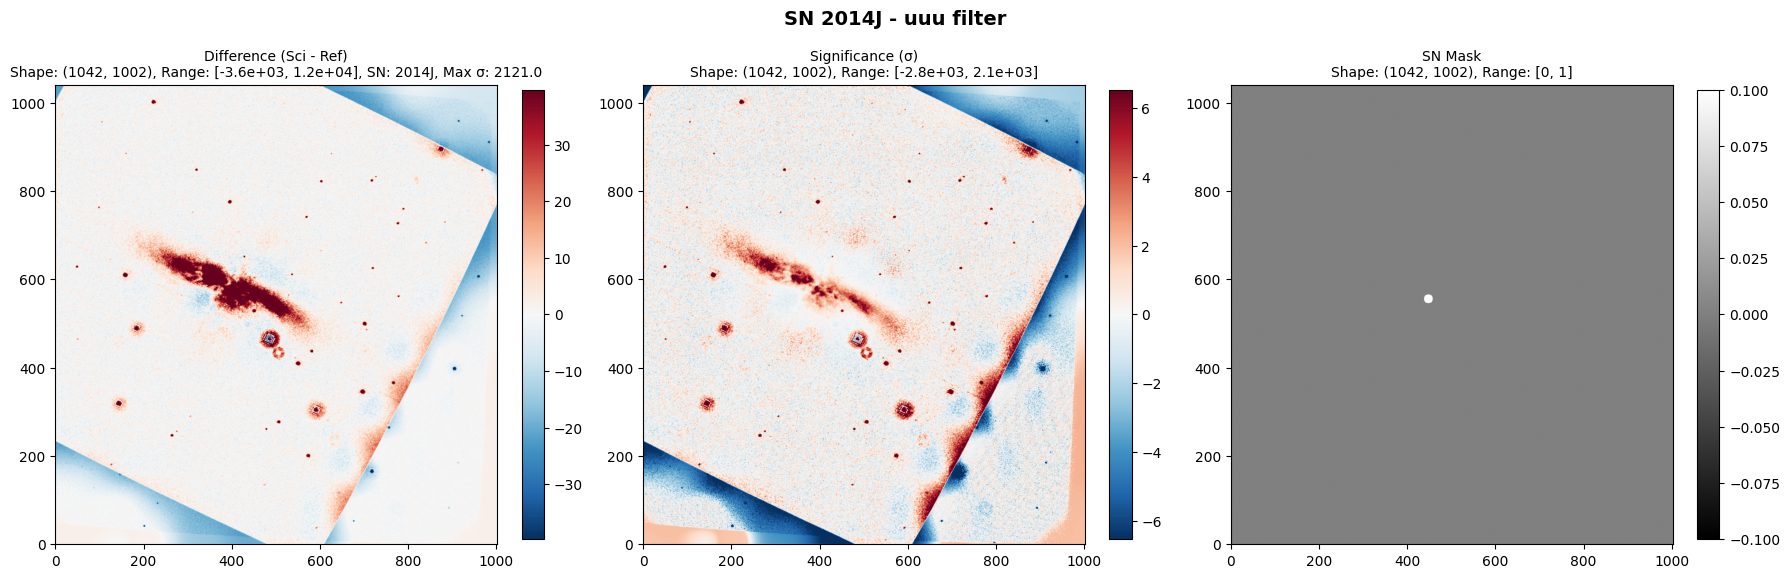

In [ ]:
# View a specific SN's difference results
SN_NAME = "2014J"  # Change this

sn_dir = Path(f"../output/difference_images/{SN_NAME}")
if sn_dir.exists():
    diff_files = list(sn_dir.glob("*_diff.fits"))
    
    for diff_file in diff_files:
        filter_name = diff_file.stem.split('_')[1]
        sig_file = sn_dir / f"{SN_NAME}_{filter_name}_sig.fits"
        mask_file = sn_dir / f"{SN_NAME}_{filter_name}_mask.fits"
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"SN {SN_NAME} - {filter_name} filter", fontsize=14, fontweight='bold')
        
        show_fits(diff_file, ax=axes[0], title="Difference (Sci - Ref)", scale='symlog')
        show_fits(sig_file, ax=axes[1], title="Significance (σ)", scale='symlog')
        show_fits(mask_file, ax=axes[2], title="SN Mask", scale='linear', cmap='gray')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"Directory not found: {sn_dir}")


## Browse All SNe - Quick Summary


Found 5 difference images:
  2013gc/2013gc_uuu_diff.fits
  2014J/2014J_uuu_diff.fits
  2014ai/2014ai_uuu_diff.fits
  2014bh/2014bh_uuu_diff.fits
  2014bi/2014bi_uvv_diff.fits


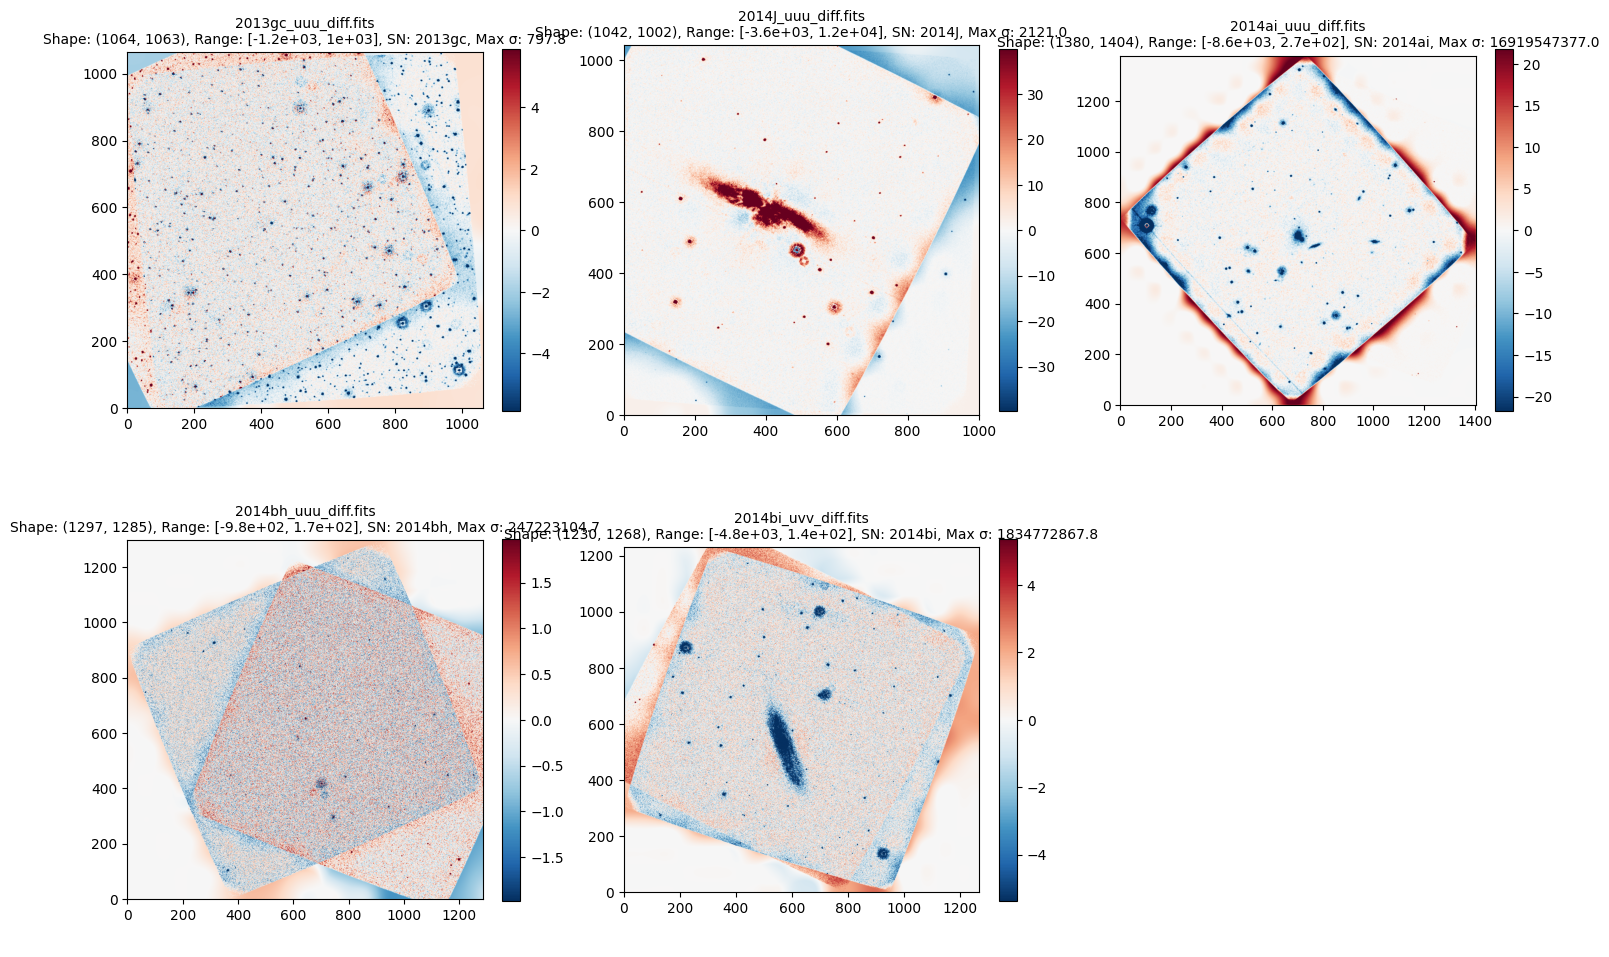

In [ ]:
# Show all difference images at once
diff_dir = Path("../output/difference_images")
all_diffs = sorted(diff_dir.rglob("*_diff.fits"))

n = len(all_diffs)
print(f"Found {n} difference images:")
for f in all_diffs:
    print(f"  {f.parent.name}/{f.name}")

if n > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < n:
            show_fits(all_diffs[i], ax=ax, scale='symlog')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No difference images found")


## Single File Deep Dive


File: ../output/difference_images/2014J/2014J_uuu_diff.fits
Shape: (1042, 1002)
Data range: [-3553, 1.183e+04]
Mean: 0.5412, Std: 33.89

Key header values:
  SN_NAME: 2014J
  FILTER: uuu
  REF_DATE: 2012-06-22
  SCI_DATE: 2014-10-10
  OVERLAP: 100.0
  SIG_MAX: 2120.953069575758
  SN_X: 447.90549527696356
  SN_Y: 555.4311832671641


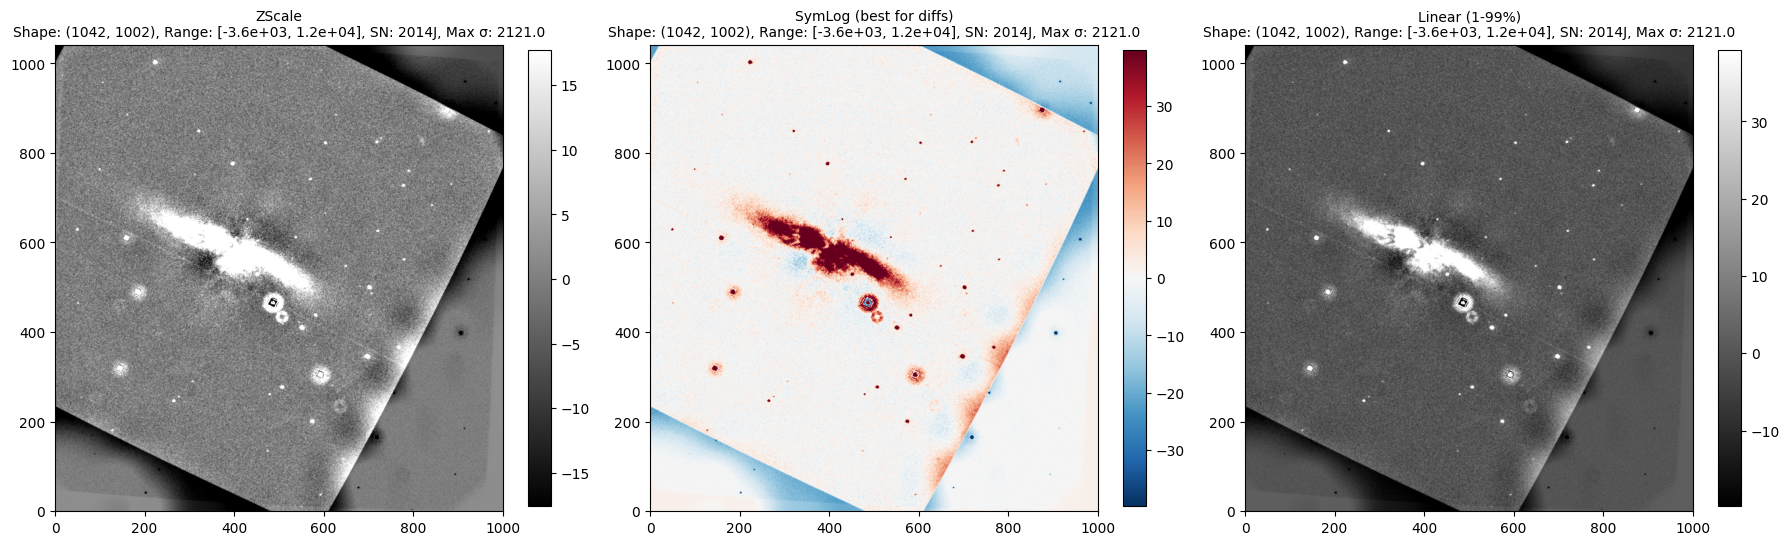

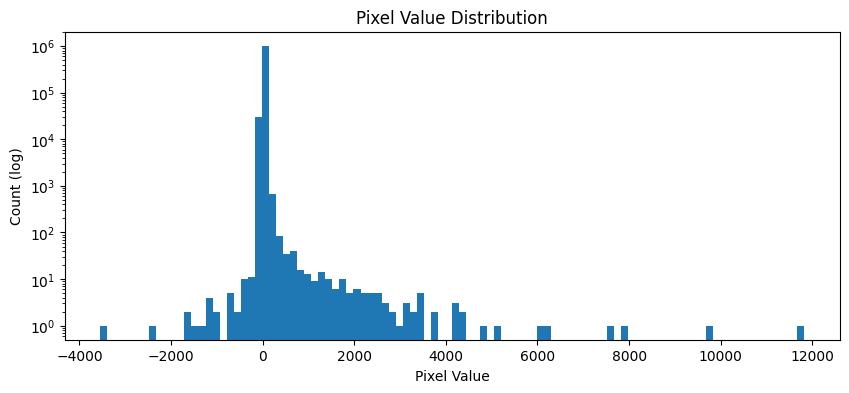

In [ ]:
# View a single file with full details
FILE = "../output/difference_images/2014J/2014J_uuu_diff.fits"  # Change this

filepath = Path(FILE)
if filepath.exists():
    data, header, wcs, ext = load_fits(filepath)
    
    print(f"File: {filepath}")
    print(f"Shape: {data.shape}")
    print(f"Data range: [{np.nanmin(data):.4g}, {np.nanmax(data):.4g}]")
    print(f"Mean: {np.nanmean(data):.4g}, Std: {np.nanstd(data):.4g}")
    
    # Show important header values
    important = ['DATE-OBS', 'SN_NAME', 'FILTER', 'REF_DATE', 'SCI_DATE', 'OVERLAP', 'SIG_MAX', 'SN_X', 'SN_Y']
    print("\nKey header values:")
    for key in important:
        if key in header:
            print(f"  {key}: {header[key]}")
    
    # Display with multiple scales
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    show_fits(filepath, ax=axes[0], title="ZScale", scale='zscale')
    show_fits(filepath, ax=axes[1], title="SymLog (best for diffs)", scale='symlog')
    show_fits(filepath, ax=axes[2], title="Linear (1-99%)", scale='linear')
    
    plt.tight_layout()
    plt.show()
    
    # Histogram
    fig, ax = plt.subplots(figsize=(10, 4))
    valid = data[np.isfinite(data)].flatten()
    ax.hist(valid, bins=100, log=True)
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Count (log)")
    ax.set_title("Pixel Value Distribution")
    plt.show()
else:
    print(f"File not found: {filepath}")
